In [2]:
from pykat import finesse       
from pykat.commands import *     
import numpy as np               
import matplotlib.pyplot as plt  
from matplotlib.ticker import FormatStrFormatter

                                              ..-
    PyKat 1.2.73          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [1]:
def frequency_noise_ASD(f):
    f = np.array(f)
    return 1e4/abs(np.random.normal(f, f/10, size=f.size))

In [3]:
def seismic_noise_ASD(f):
    f = np.array(f)
    N = 1e-1/abs(np.random.normal(f**15, f/2, size=f.size))
    N += 1e-28
    return N

################################ Transfer Function ##############################################

In [4]:
kat = finesse.kat()          
kat.verbose = False          

In [5]:
code = """

            l laser 2 0 n0            # Laser with 0 offset wavelength (thus default 1064nm used)
            s s1 1 n0 n1              # Space from laser to mirror (1 m)
            fsig sig1 laser amp 1 0 1 # Laser power fluctuations (freq 1 Hz, phase 0, amplitude 1)
            # Demodulate our signal to compute a transfer function
            
            
            pd1 tf $fs n1 
            # Sweep the frequency of the signal applied from 10kHz to 1GHz in 1000 steps
            
            xaxis sig1 f log 10k 1G 1000
            yaxis abs:deg
"""

In [6]:
kat.parse(code)                                  
out = kat.run()

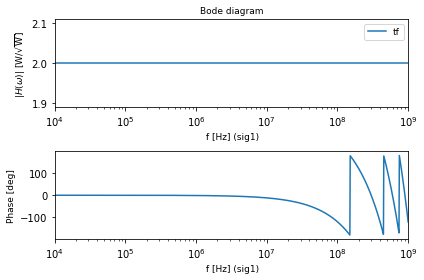

In [7]:
fig = out.plot(title='Bode diagram',
               ylabel='$|H(\omega)|$ $[\mathrm{W}/\sqrt{\mathrm{W}}]$',
               detectors=["tf"])

################### core setup ##########################################

In [8]:
base = finesse.kat()          
base.verbose = False          

In [15]:
base.parse(""" 

            l laser 1M 0 n0                        # Laser (P=1MW, 0 wavelength offset from 1064nm)          
            s s0 1 n0 nBSb                         # Space from laser to beam splitter (1 m)<br>
            ## Central beam splitter ##
            bs BS 0.5 0.5 0 45 nBSb nBSy nBSx nBSd # Central beam splitter (0.5 refl, 0.5 trans, 0 deg. tuning
                                                #                        45 degrees angle of incidence)                                                            
            ## X arm ##
            s LX 4000 nBSx nMX1                    # Space: Length of X arm <br>
            m MX 1 0 -45.003 nMX1 nMX2             # Mirror MX (R=1, T=0, -45deg tuning)<br>
            ## Y arm ##<br>
            s LY 4000.01 nBSy nMY1                 # Space: Length of Y arm <br>
            m MY 1 0 45.003 nMY1 nMY2              # Mirror MY (R=1, T=0, +45deg tuning)<br>
            ## Output ##<br>
            s sout 1 nBSd nout                     # Space from BS to the photodiode (1 m)<br>
         """)   

############## amplitude TF#######################

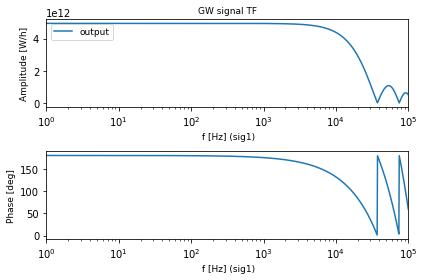

In [16]:
kat = base.deepcopy()
kat.parse("""
            fsig sig1 LX 1 0 1
            fsig sig1 LY 1 180 1
            pd1 output $fs nout
            xaxis sig1 f log 1 100k 1000
            yaxis abs:deg
""")
MichTF = kat.run() 
MichTF.plot(ylabel='Amplitude [W/h]',title='GW signal TF')

#################Frequency response

In [17]:
kat = base.deepcopy()
kat.parse("""
            fsig sig1 laser freq 1 0 1
            pd1 output $fs nout
            xaxis sig1 f log 1 100k 1000
            yaxis abs:deg
""")

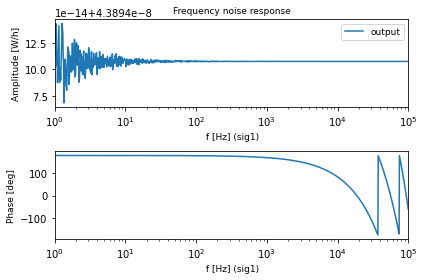

In [18]:
MichFresp = kat.run()
MichFresp.plot(ylabel='Amplitude [W/h]',title='Frequency noise response')

################Frequency sesnsitvity################

In [19]:
def Sf(Nf,Hn,Hs):
    return(Nf*Hn)/Hs

In [20]:
f = MichTF.x
N_f_asd = frequency_noise_ASD(f)

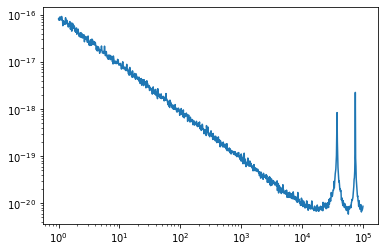

In [21]:
Hn = abs(MichFresp['output'])
Hs = abs(MichTF['output'])
S_f = Sf(N_f_asd,Hn,Hs)
plt.loglog(f, S_f)

Text(0.5, 1.0, 'Frequency Noise Limited Sensitivity')

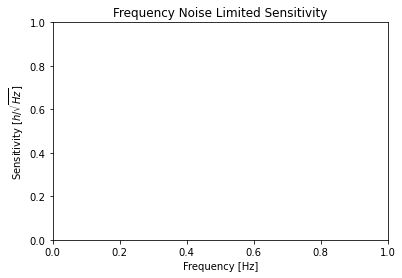

In [52]:
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity [$h/\sqrt{Hz}$]")
plt.title('Frequency Noise Limited Sensitivity')

X mirror TF

In [53]:
kat = base.deepcopy()
kat.parse("""
            fsig sig1 MX z 1 0 1
            pd1 output $fs nout
            xaxis sig1 f log 1 100k 1000
            yaxis abs:deg
""")

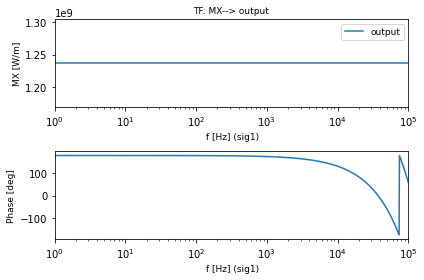

In [54]:
out = kat.run()
Hmx = abs(out['output']) 
fig = out.plot(ylabel="MX [W/m]", title='TF: MX--> output')

Y mirror TF

In [55]:
kat = base.deepcopy()
kat.parse("""
fsig sig1 MY z 1 0 1
pd1 output $fs nout
xaxis sig1 f log 1 100k 1000
yaxis abs:deg
""")

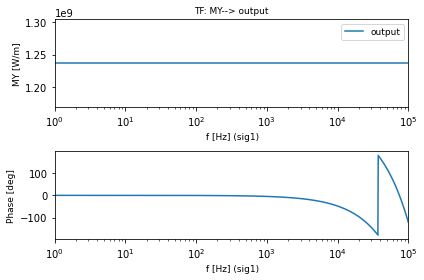

In [56]:
out = kat.run()
Hmy = abs(out['output']) # Here we save the transfer function to use later too
fig = out.plot(ylabel="MY [W/m]", title='TF: MY--> output')

######################### sensitivity seismic noise

In [57]:
f = out.x               
N_s_asd = seismic_noise_ASD(f)

In [58]:
S_s = np.sqrt((N_s_asd * Hmx / Hs)**2 + (N_s_asd * Hmy / Hs)**2)

Text(0, 0.5, 'Sensitivity [$h/\\sqrt{Hz}$]')

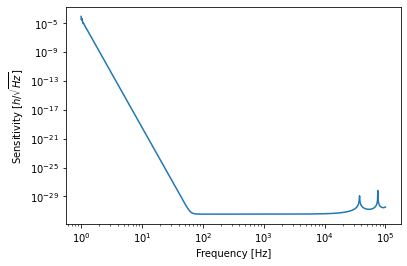

In [59]:
plt.figure()
plt.loglog(f, S_s)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity [$h/\sqrt{Hz}$]")

###########################quantum nois

In [60]:
kat = base.deepcopy()
kat.parse("""
fsig noise 1
qnoised qn 1 $fs nout
xaxis noise f log 1 100k 1000
""")

In [61]:
out = kat.run()
f = out.x   
S_q = out['qn'] / Hs 

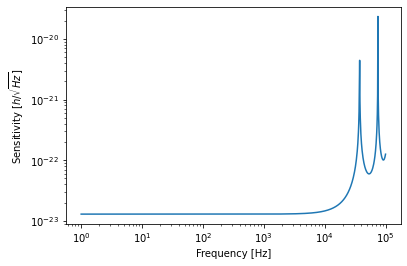

In [62]:
plt.figure()
plt.loglog(f, S_q)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity [$h/\sqrt{Hz}$]");

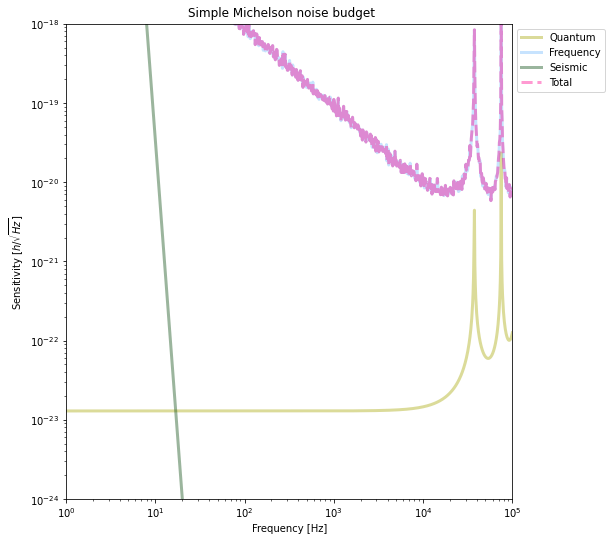

In [63]:

 fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.loglog(f, S_q, label="Quantum", alpha=0.4, color='xkcd:puke', linewidth=3)
ax.loglog(f, S_f, label="Frequency", alpha=0.4, color='xkcd:sky blue', linewidth=3)
ax.loglog(f, S_s, label="Seismic",alpha=0.4, color='xkcd:forest green', linewidth=3)
total = np.sqrt(S_q**2 + S_f**2 + S_s**2)
ax.loglog(f, total, label="Total", alpha=0.4, color='xkcd:electric pink', linewidth=3, linestyle='--')
ax.set_ylim(1e-24, 1e-18)
ax.legend(loc=2,bbox_to_anchor=(1,1))
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Sensitivity [$h/\sqrt{Hz}$]")
fig.suptitle('Simple Michelson noise budget')
fig.subplots_adjust(top=0.95) 

plt.margins(0, 0)

In [64]:
freq_factor = 2500
S_f_2 = S_f/freq_factor 

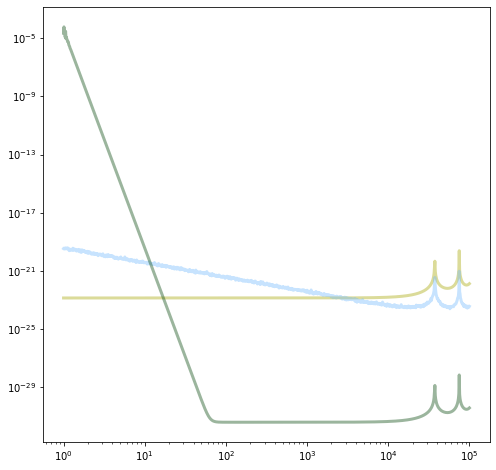

In [49]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.loglog(f, S_q, label="Quantum", alpha=0.4, color='xkcd:puke', linewidth=3)
ax.loglog(f, S_f_2, label="Frequency", alpha=0.4, color='xkcd:sky blue', linewidth=3)
ax.loglog(f, S_s, label="Seismic",alpha=0.4, color='xkcd:forest green', linewidth=3)

In [50]:
total = np.sqrt(S_q**2 + S_f_2**2 + S_s**2)
ax.loglog(f, total, label="Total", alpha=0.4, color='xkcd:electric pink', linewidth=3, linestyle='--')

In [51]:
ax.set_ylim(1e-24, 1e-18)
ax.legend(loc=2,bbox_to_anchor=(1,1))
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Sensitivity [$h/\sqrt{Hz}$]")
fig.suptitle('Simple Michelson noise budget with reduced frequency noise');
fig.subplots_adjust(top=0.95)